In [1]:
import sys
import os
import time
import logging
import datetime
from datetime import datetime, timedelta
import yaml
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import requests
import pandas_gbq
from dreams_core.googlecloud import GoogleCloud as dgc
from dreams_core import core as dc
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# load dotenv
load_dotenv()


# import local files if necessary
sys.path.append('..//src')
from utils import load_config, cw_filter_df
import training_data as td
importlib.reload(td)
import feature_engineering as fe
importlib.reload(fe)
import coin_wallet_metrics as cwm
importlib.reload(cwm)


# configure logger
logger = dc.setup_logger()
logger.setLevel(logging.INFO)

# Custom format function for displaying numbers
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')

#### Load the datasets

In [2]:
importlib.reload(td)
config = load_config()


# retrieve prices data
prices_df = td.retrieve_prices_data()

# fill gaps in prices data
prices_df,_ = td.fill_prices_gaps(prices_df,config['data_cleaning']['max_gap_days'])
logger.info(f"Prices data shape: {prices_df.shape}")

# retrieve transfers data
transfers_df = td.retrieve_transfers_data(
    config['training_data']['training_period_start'],
    config['training_data']['modeling_period_start'],
    config['training_data']['modeling_period_end']
    )

# compile profits_df
profits_df = td.prepare_profits_data(transfers_df, prices_df)
profits_df = td.calculate_wallet_profitability(profits_df)
profits_df,_ = td.clean_profits_df(profits_df, config['data_cleaning'])


# identify sharks
shark_coins_df = td.classify_shark_coins(profits_df, config['training_data'])
shark_wallets_df = td.classify_shark_wallets(shark_coins_df,config['training_data'])


# assess shark performance
shark_agg_performance_df,shark_wallets_performance_df = td.calculate_shark_performance(transfers_df, prices_df, shark_wallets_df, config)
metrics = ['count_wallets', 'return_aggregate', 'nonzero_count_wallets', 'nonzero_median_return', 'midrange_count_wallets', 'midrange_median_return', 'midrange_return_aggregate']
shark_agg_performance_df[shark_agg_performance_df['metric'].isin(metrics)]

[11/Sep/2024 17:14:37] INFO [dreams_core.core.retrieve_prices_data:42] retrieved prices data with shape (120763, 3)
[11/Sep/2024 17:14:37] INFO [dreams_core.core.fill_prices_gaps:126] 382 coins had no gaps, 19 coins had gaps filled, and 38 coins were dropped due to large gaps.
[11/Sep/2024 17:14:37] INFO [dreams_core.core.<module>:10] Prices data shape: (110929, 3)
[11/Sep/2024 17:15:10] INFO [dreams_core.core.retrieve_transfers_data:414] retrieved transfers_df with shape (25520299, 5) after 33.4 seconds.
[11/Sep/2024 17:15:10] INFO [dreams_core.core.<module>:18] Transfers data shape: (25520299, 5)
[11/Sep/2024 17:15:10] INFO [dreams_core.core.prepare_profits_data:455] Preparing profits_df data...
[11/Sep/2024 17:16:07] INFO [dreams_core.core.calculate_wallet_profitability:635] Generated profits df after 23.16 seconds
[11/Sep/2024 17:16:33] INFO [dreams_core.core.clean_profits_df:706] Finished cleaning profits_df after 25.97 seconds.
[11/Sep/2024 17:16:34] INFO [dreams_core.core.<modul

,metric,not_sharks,sharks
0,count_wallets,123289,359
16,return_aggregate,0.179134088689,0.301022375773
17,nonzero_count_wallets,26418,158
26,nonzero_median_return,0.00010879868112,2.05712828155e-06
28,midrange_count_wallets,21134,126
37,midrange_median_return,0.000157382920216,2.60015426069e-06
38,midrange_return_aggregate,0.0534550199281,0.147663049798


In [12]:
importlib.reload(td)
config = load_config()

# identify sharks
shark_coins_df = td.classify_shark_coins(profits_df, config['training_data'])
shark_wallets_df = td.classify_shark_wallets(shark_coins_df,config['training_data'])

training_profits_df = profits_df[profits_df['date']<=config['training_data']['training_period_end']]

cohort_wallets = shark_wallets_df[shark_wallets_df['is_shark']==True]['wallet_address'].unique()
cohort_coins = shark_coins_df['coin_id'].unique()
print(len(cohort_wallets))
print(len(cohort_coins))

# retrieve metadata and filtered profits_df
metadata_df,cohort_profits_df = cwm.prepare_feature_datasets(training_profits_df,cohort_wallets,cohort_coins)

[11/Sep/2024 17:27:13] INFO [dreams_core.core.classify_shark_coins:772] creation of shark_coins_df complete.
[11/Sep/2024 17:27:14] INFO [dreams_core.core.prepare_datasets:33] Preparing cohort_profits_df...


998
139


[11/Sep/2024 17:27:18] INFO [dreams_core.core.prepare_datasets:77] Generated cohort_profits_df after 3.82 seconds.


In [15]:
profits_df.head()

,coin_id,wallet_address,date,net_transfers,balance,price,profits_change,profits_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_inflows_cumulative,total_return
0,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-23,5.2e-08,5.2e-08,1.88983550773,0,0,9.82714464018e-08,9.82714464018e-08,9.82714464018e-08,9.82714464018e-08,0
1,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-28,0.002920722,0.002920774,7.47303212902,2.90326224307e-07,2.90326224307e-07,0.0218270379436,0.0218266493459,0.0218266493459,0.0218267476174,1.33013964974e-05
2,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-04-02,1.75,1.752920774,34.7437187048,0.0796515123126,0.0796518026389,60.9029862836,60.8015077334,60.8015077334,60.823334481,0.00130955994634
3,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-04-03,0.227311948,1.980232722,29.1074847768,-9.87987153956,-9.80021973693,57.6395938101,6.61647906598,6.61647906598,67.439813547,-0.145318013522
4,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-04-04,0.017896359,1.998129081,24.2238754725,-9.67068294575,-19.4709026827,48.4024300361,0.433519171827,0.433519171827,67.8733327188,-0.286871174624


In [13]:
importlib.reload(cwm)

buysell_metrics_df = cwm.generate_buysell_metrics_df(cohort_profits_df)
buysell_metrics_df


[11/Sep/2024 17:27:18] INFO [dreams_core.core.generate_buysell_metrics_df:95] Preparing buysell_features_df...
[11/Sep/2024 17:27:20] INFO [dreams_core.core.generate_buysell_metrics_df:117] Generated buysell_features_df after 2.45 seconds.


,date,buyers_new,buyers_repeat,total_buyers,sellers_new,sellers_repeat,total_sellers,total_bought,total_sold,total_net_transfers,total_volume,total_holders,total_balance,coin_id
0,2024-03-13,20,2,22,0,0,0,73649.83617,0,73649.83617,73649.83617,20,83658.541775,04f6120a-f0dd-4260-bb2b-b8f827fdba61
1,2024-03-14,2,0,2,2,0,2,5420.2621442,3279.53765231,2140.72449189,8699.79979651,4,13148.8171354,04f6120a-f0dd-4260-bb2b-b8f827fdba61
2,2024-03-15,3,0,3,1,0,1,6435.64314486,1876.35561669,4559.28752817,8311.99876155,4,6731.13464433,04f6120a-f0dd-4260-bb2b-b8f827fdba61
3,2024-03-16,0,2,2,1,1,2,1547.12713762,5418.07204041,-3870.94490279,6965.19917802,4,6735.78147101,04f6120a-f0dd-4260-bb2b-b8f827fdba61
4,2024-03-17,0,2,2,0,1,1,579.271114799,1537.95538848,-958.684273681,2117.22650328,3,7395.7597263,04f6120a-f0dd-4260-bb2b-b8f827fdba61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6664,2024-04-25,0,0,0,0,3,3,0,1675480.54129,-1675480.54129,1675480.54129,3,404187,fd1f38d9-5c05-4809-80fe-b67a07fd345c
6665,2024-04-26,0,0,0,0,1,1,0,404187,-404187,404187,1,-7.27595761418e-11,fd1f38d9-5c05-4809-80fe-b67a07fd345c
6666,2024-04-27,0,3,3,0,0,0,433498.485203,0,433498.485203,433498.485203,3,1496896.2854,fd1f38d9-5c05-4809-80fe-b67a07fd345c
6667,2024-04-28,0,0,0,1,0,1,0,717928.578161,-717928.578161,717928.578161,1,4.36557456851e-11,fd1f38d9-5c05-4809-80fe-b67a07fd345c


In [9]:
importlib.reload(fe)

metrics = ['buyers_new', 'buyers_repeat', 'total_buyers', 'sellers_new', 'sellers_repeat', 'total_sellers']
result_df = fe.process_all_coins(buysell_metrics_df, metrics, window_sizes=[7, 30], 
                              bollinger_window=20, decompose_model='additive', freq=7)


In [67]:
buysell_metrics_df

,date,buyers_new,buyers_repeat,total_buyers,sellers_new,sellers_repeat,total_sellers,coin_id
0,2024-03-13,7,1,8,0,0,0,04f6120a-f0dd-4260-bb2b-b8f827fdba61
1,2024-03-14,1,0,1,2,0,2,04f6120a-f0dd-4260-bb2b-b8f827fdba61
2,2024-03-15,1,0,1,1,0,1,04f6120a-f0dd-4260-bb2b-b8f827fdba61
3,2024-03-16,0,1,1,1,1,2,04f6120a-f0dd-4260-bb2b-b8f827fdba61
4,2024-03-17,0,0,0,0,1,1,04f6120a-f0dd-4260-bb2b-b8f827fdba61
...,...,...,...,...,...,...,...,...
4204,2024-04-24,0,0,0,0,1,1,fd1f38d9-5c05-4809-80fe-b67a07fd345c
4205,2024-04-25,0,0,0,0,1,1,fd1f38d9-5c05-4809-80fe-b67a07fd345c
4206,2024-04-26,0,0,0,0,1,1,fd1f38d9-5c05-4809-80fe-b67a07fd345c
4207,2024-04-29,0,0,0,1,0,1,fd1f38d9-5c05-4809-80fe-b67a07fd345c


[11/Sep/2024 17:14:12] INFO [dreams_core.core.generate_buysell_metrics_df:93] Preparing buysell_features_df...
[11/Sep/2024 17:14:13] INFO [dreams_core.core.generate_buysell_metrics_df:115] Generated buysell_features_df after 1.25 seconds.


,date,buyers_new,buyers_repeat,total_buyers,sellers_new,sellers_repeat,total_sellers,coin_id
0,2024-03-13,7,1,8,0,0,0,04f6120a-f0dd-4260-bb2b-b8f827fdba61
1,2024-03-14,1,0,1,2,0,2,04f6120a-f0dd-4260-bb2b-b8f827fdba61
2,2024-03-15,1,0,1,1,0,1,04f6120a-f0dd-4260-bb2b-b8f827fdba61
3,2024-03-16,0,1,1,1,1,2,04f6120a-f0dd-4260-bb2b-b8f827fdba61
4,2024-03-17,0,0,0,0,1,1,04f6120a-f0dd-4260-bb2b-b8f827fdba61
...,...,...,...,...,...,...,...,...
4204,2024-04-24,0,0,0,0,1,1,fd1f38d9-5c05-4809-80fe-b67a07fd345c
4205,2024-04-25,0,0,0,0,1,1,fd1f38d9-5c05-4809-80fe-b67a07fd345c
4206,2024-04-26,0,0,0,0,1,1,fd1f38d9-5c05-4809-80fe-b67a07fd345c
4207,2024-04-29,0,0,0,1,0,1,fd1f38d9-5c05-4809-80fe-b67a07fd345c


In [66]:
# Set pandas option to display 204 rows
pd.set_option('display.max_rows', 204)


summary_stats = result_df.describe()
summary_stats.T.to_csv('stats.csv',index=True)
summary_stats.T

,count,mean,std,min,25%,50%,75%,max
buyers_new_mean,111,0.612058690705,0.346019872031,0.0247933884298,0.413461538462,0.533333333333,0.738791423002,2.33333333333
buyers_new_std,111,1.7458863728,1.31422118039,0.202600177581,0.722715224074,1.32381620002,2.29941710834,6.41756593503
buyers_new_min,111,0,0,0,0,0,0,0
buyers_new_max,111,10.4144144144,12.0811411776,1,2,6,13.5,66
buyers_new_median,111,0.0720720720721,0.250878881017,0,0,0,0,1.5
buyers_new_last_value,111,0.018018018018,0.133619676149,0,0,0,0,1
buyers_new_kurtosis,102,26.2791437029,29.8045002302,-6,4,12.630316263,43.9706006945,114.769550838
buyers_new_skewness,107,4.04372614949,2.83472444304,-1.22963409192,1.90839941257,3.32584838945,6.21821688223,10.59106505
buyers_new_autocorrelation,92,0.208195889991,0.299334138797,-0.385922492494,-0.053022327883,0.175485558811,0.429356177708,0.870388279778
buyers_new_z_score,111,-0.439289696274,0.260052153445,-1.46385010942,-0.579512659968,-0.380685328294,-0.240676130896,0.442718872424


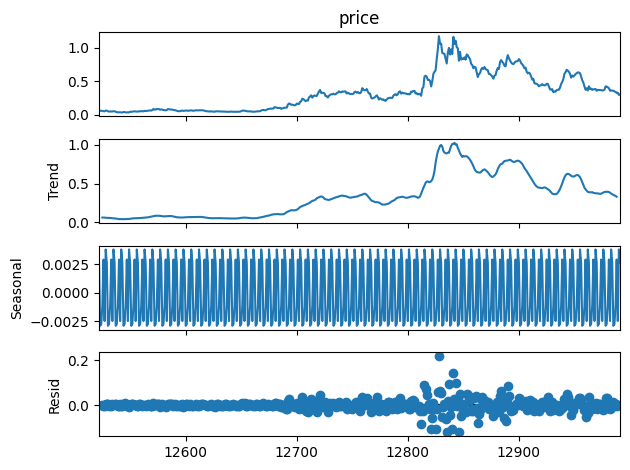

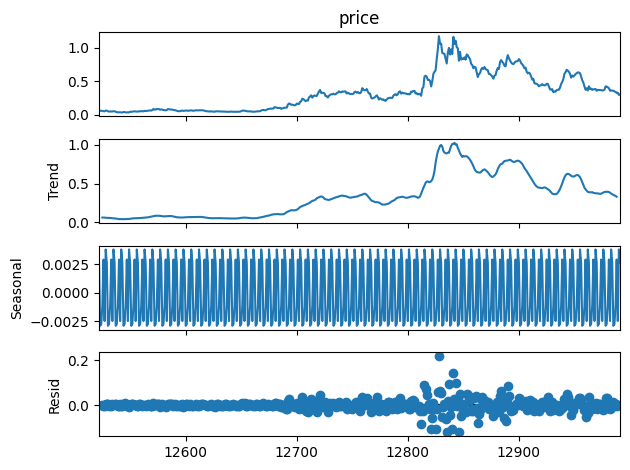

In [41]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def decompose_time_series(ts, model='additive', freq=None):
    """
    Decomposes a time series into trend, seasonal, and residual components.

    Params:
    - ts (pd.Series): A single time series (e.g., price data).
    - model (str): 'additive' or 'multiplicative' decomposition.
    - freq (int): The frequency of the seasonality (e.g., 7 for weekly, 30 for monthly).

    Returns:
    - decomposition (DecomposeResult): The result of the seasonal decomposition.
    """
    decomposition = seasonal_decompose(ts, model=model, period=freq)
    
    # Plot the decomposition
    decomposition.plot()
    plt.show()

    return decomposition


# Assuming `price_data` is a time series of prices for a single coin
price_data = prices_df[prices_df['coin_id'] == coins[45]]['price']

# Decompose the time series (e.g., with weekly seasonality)
decomposition = decompose_time_series(price_data, model='additive', freq=7)

decomposition = seasonal_decompose(price_data, model='additive', period=7)
decomposition.plot()
plt.show()


In [42]:
decomposition

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def decompose_time_series(ts, model='additive', freq=None):
    """
    Decomposes a time series into trend, seasonal, and residual components.

    Params:
    - ts (pd.Series): A single time series (e.g., price data).
    - model (str): 'additive' or 'multiplicative' decomposition.
    - freq (int): The frequency of the seasonality (e.g., 7 for weekly, 30 for monthly).

    Returns:
    - decomposition (DecomposeResult): The result of the seasonal decomposition.
    """
    decomposition = seasonal_decompose(ts, model=model, period=freq)
    
    # Plot the decomposition
    decomposition.plot()
    plt.show()

    return decomposition


# Assuming `price_data` is a time series of prices for a single coin
price_data = features_df[features_df['coin_id'] == '04f6120a-f0dd-4260-bb2b-b8f827fdba61']['price']

# Decompose the time series (e.g., with weekly seasonality)
decomposition = decompose_time_series(price_data, model='additive', freq=7)


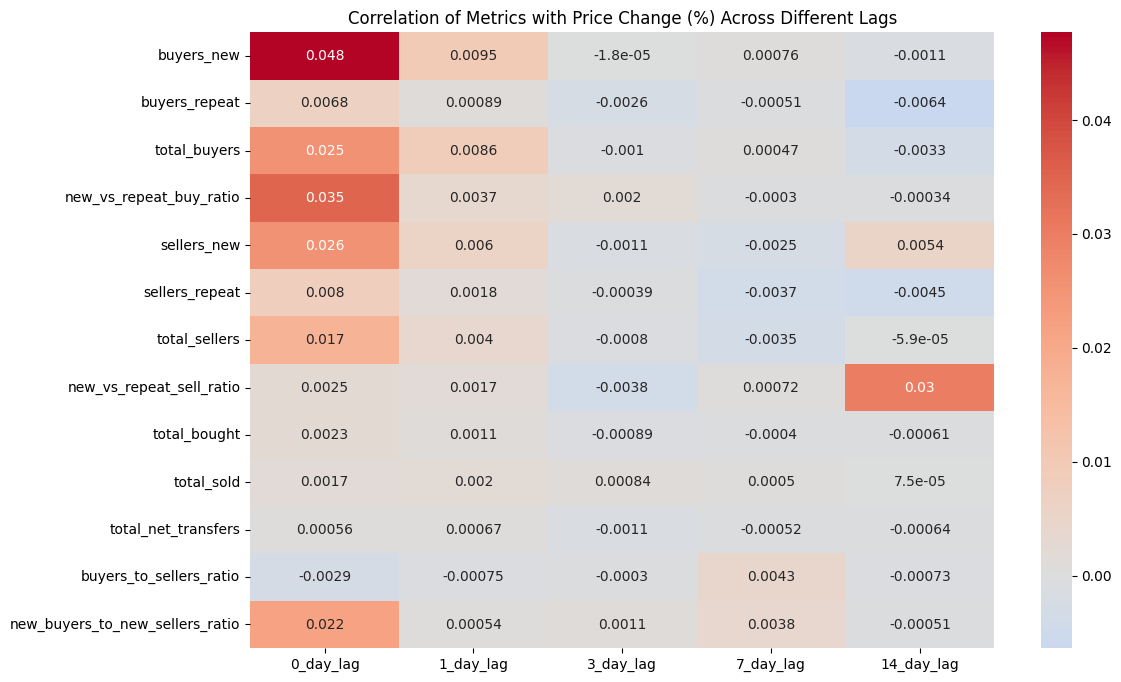

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

features_df = buysell_features_df

# Step 1: Merge DataFrames on 'coin_id' and 'date'
merged_df = pd.merge(features_df, prices_df, on=['coin_id', 'date'])

# Step 2: Calculate price percentage change
merged_df['price_change_pct'] = merged_df.groupby('coin_id')['price'].pct_change()

# Step 3: Select numeric columns (exclude price and price_change_pct)
metrics_cols = merged_df.select_dtypes(include=[float, int]).columns
metrics_cols = metrics_cols.drop(['price', 'price_change_pct'])

# Initialize a DataFrame to store correlations across different lags
lagged_correlations = pd.DataFrame(index=metrics_cols)

# Step 4: Calculate correlation for each lag
for lag in [0, 1, 3, 7, 14]:
    # Shift the metrics by the specified lag
    lagged_df = merged_df.copy()
    lagged_df[metrics_cols] = lagged_df.groupby('coin_id')[metrics_cols].shift(lag)
    
    # Calculate correlation of metrics with price_change_pct
    correlation = lagged_df[metrics_cols].corrwith(lagged_df['price_change_pct'])
    
    # Store in the DataFrame
    lagged_correlations[f'{lag}_day_lag'] = correlation

# Step 5: Plot heatmap for correlations across different lags
plt.figure(figsize=(12, 8))
sns.heatmap(lagged_correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Metrics with Price Change (%) Across Different Lags')
plt.show()


In [54]:
importlib.reload(cwm)

buysell_df = cwm.calculate_buyer_seller_counts(coin_cohort_profits_df)
buysell_df.head()

/Users/jeremymeadow/DreamsData/GitHub/data-science/notebooks/..//src/coin_wallet_metrics.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ,wt.wallet_address


,date,buyers_new,buyers_repeat,total_buyers,new_vs_repeat_buy_ratio,sellers_new,sellers_repeat,total_sellers,new_vs_repeat_sell_ratio,total_bought,total_sold,total_net_transfers,buyers_to_sellers_ratio,new_buyers_to_new_sellers_ratio,sentiment_score
0,2024-03-13,227,20,247,11.35,0,0,0,0,1289758.53651,0,1289758.53651,0,0,1
1,2024-03-14,58,11,69,5.27272727273,40,0,40,0,139494.132729,126818.533696,12675.5990335,1.725,1.45,1
2,2024-03-15,19,18,37,1.05555555556,19,6,25,3.16666666667,66736.9112817,63560.1092951,3176.80198666,1.48,1,1
3,2024-03-16,20,17,37,1.17647058824,12,9,21,1.33333333333,66147.7670843,54511.8430239,11635.9240604,1.7619047619,1.66666666667,1
4,2024-03-17,24,17,41,1.41176470588,16,8,24,2,48536.1127564,38110.7740611,10425.3386954,1.70833333333,1.5,1


In [55]:
prices_df

,date,coin_id,price
0,2024-03-11,004cb3d0-0803-4208-a9e1-c3457567ea3f,0.0018422483042
1,2024-03-12,004cb3d0-0803-4208-a9e1-c3457567ea3f,0.0018422483042
2,2024-03-13,004cb3d0-0803-4208-a9e1-c3457567ea3f,0.00185346149497
3,2024-03-14,004cb3d0-0803-4208-a9e1-c3457567ea3f,0.00371872447609
4,2024-03-15,004cb3d0-0803-4208-a9e1-c3457567ea3f,0.00329463860539
...,...,...,...
110924,2024-09-01,fe5bc8b4-817b-4a05-9d15-5d770cc75ad2,3.86452699976e-09
110925,2024-09-02,fe5bc8b4-817b-4a05-9d15-5d770cc75ad2,3.97322070995e-09
110926,2024-09-03,fe5bc8b4-817b-4a05-9d15-5d770cc75ad2,5.00002620942e-09
110927,2024-09-04,fe5bc8b4-817b-4a05-9d15-5d770cc75ad2,4.43496010107e-09


In [53]:
buysell_df

,date,buyers_new,buyers_repeat,total_buyers,new_vs_repeat_buy_ratio,sellers_new,sellers_repeat,total_sellers,new_vs_repeat_sell_ratio,total_bought,total_sold,total_net_transfers,buyers_to_sellers_ratio,new_buyers_to_new_sellers_ratio,sentiment_score
0,2024-03-13,227,20,247,11.35,0,0,0,0,1289758.53651,0,1289758.53651,0,0,1
1,2024-03-14,58,11,69,5.27272727273,40,0,40,0,139494.132729,126818.533696,12675.5990335,1.725,1.45,1
2,2024-03-15,19,18,37,1.05555555556,19,6,25,3.16666666667,66736.9112817,63560.1092951,3176.80198666,1.48,1,1
3,2024-03-16,20,17,37,1.17647058824,12,9,21,1.33333333333,66147.7670843,54511.8430239,11635.9240604,1.7619047619,1.66666666667,1
4,2024-03-17,24,17,41,1.41176470588,16,8,24,2,48536.1127564,38110.7740611,10425.3386954,1.70833333333,1.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2024-05-27,3,23,26,0.130434782609,2,11,13,0.181818181818,14209.7544157,18483.970496,-4274.21608029,2,1.5,1
76,2024-05-28,3,9,12,0.333333333333,1,13,14,0.0769230769231,2982.2310262,15377.0332979,-12394.8022717,0.857142857143,3,1
77,2024-05-29,3,11,14,0.272727272727,3,8,11,0.375,3340.19448835,3483.06154663,-142.86705828,1.27272727273,1,1
78,2024-05-30,1,10,11,0.1,3,3,6,1,3143.33729789,1556.07697927,1587.26031861,1.83333333333,0.333333333333,1


In [50]:
coin_cohort_profits_df.head()

,coin_id,wallet_address,date,balance,net_transfers,buy_sequence,sell_sequence
58,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-17,858.493983617,858.493983617,1,NaN
59,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-18,1380.57515462,522.081170999,2,NaN
60,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-24,69.02875773,-1311.54639689,NaN,1
61,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-04-30,69.02875773,0,NaN,NaN
62,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-05-01,69.02875773,0,NaN,NaN


In [41]:
start_time = time.time()

# Ensure 'date' column is of datetime type
cohort_profits_df['date'] = pd.to_datetime(cohort_profits_df['date'])

# Group by 'date' and calculate the counts
buyers_df = cohort_profits_df.groupby('date').agg(
    buyers_new = ('buy_sequence', lambda x: (x == 1).sum()),
    buyers_repeat = ('buy_sequence', lambda x: (x != 1).sum())
).reset_index()

# Set 'date' as the index
buyers_df.set_index('date', inplace=True)

# Fill empty cells with 0s
buyers_df.fillna(0, inplace=True)

logger.debug('New vs repeat buyer counts complete after %.2f seconds', time.time() - start_time)

buyers_df

,buyers_new,buyers_repeat
date,,
2024-01-01,75516,0
2024-01-02,1258,3289
2024-01-03,1115,3855
2024-01-04,1379,3952
2024-01-05,851,3738
...,...,...
2024-05-27,354,6258
2024-05-28,320,5952
2024-05-29,238,6136


In [32]:
cohort_df = profits_df[
    (profits_df['wallet_address'].isin(cohort_wallets)) &
    (profits_df['coin_id'].isin(cohort_coins))
]
cohort_df = cohort_df[['coin_id','wallet_address','date','balance','net_transfers']]

# Initialize the buy and sell sequence columns
cohort_df['buy_sequence'] = np.where(cohort_df['net_transfers'] > 0, 1, np.nan)
cohort_df['sell_sequence'] = np.where(cohort_df['net_transfers'] < 0, 1, np.nan)

# Calculate cumulative sum to simulate transfer sequence, skipping rows where net_transfers == 0
cohort_df['buy_sequence'] = cohort_df.groupby(['coin_id', 'wallet_address'])['buy_sequence'].cumsum()
cohort_df['sell_sequence'] = cohort_df.groupby(['coin_id', 'wallet_address'])['sell_sequence'].cumsum()

# Set buy_sequence and sell_sequence to null where net_transfers == 0
cohort_df.loc[cohort_df['net_transfers'] == 0, ['buy_sequence', 'sell_sequence']] = np.nan

# View the updated DataFrame
cohort_df[['coin_id', 'wallet_address', 'date', 'balance', 'net_transfers', 'buy_sequence', 'sell_sequence']].head()

cohort_df.head()

,coin_id,wallet_address,date,balance,net_transfers,buy_sequence,sell_sequence
58,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-17,858.493983617,858.493983617,1,NaN
59,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-18,1380.57515462,522.081170999,2,NaN
60,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-24,69.02875773,-1311.54639689,NaN,1
61,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-04-30,69.02875773,0,NaN,NaN
62,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-05-01,69.02875773,0,NaN,NaN


In [38]:
cohort_df.shape

(1988507, 7)

In [36]:
import pandas as pd
import random

# Sample coin-wallet pair from the dataset
random_coin_wallet_pair = cohort_df[['coin_id', 'wallet_address']].drop_duplicates().sample(1).iloc[0]

# Function to output all rows for a given coin-wallet pair sorted by date
def get_sorted_coin_wallet_data(df, coin_id, wallet_address):
    filtered_df = df[(df['coin_id'] == coin_id) & (df['wallet_address'] == wallet_address)]
    sorted_df = filtered_df.sort_values(by='date')
    return sorted_df

# Extract the coin_id and wallet_address from the random pair
coin_id = random_coin_wallet_pair['coin_id']
wallet_address = random_coin_wallet_pair['wallet_address']

# Run the function and output the result
sorted_coin_wallet_data = get_sorted_coin_wallet_data(cohort_df, coin_id, wallet_address)
sorted_coin_wallet_data


,coin_id,wallet_address,date,balance,net_transfers,buy_sequence,sell_sequence
2320789,147bb5ef-598b-48bd-b814-583f973c2a4a,0x56c80fe581432cea3d8a1effb94b58a40f2e4e8d,2024-03-29,2601.94687114,2601.94687114,1,NaN
2320790,147bb5ef-598b-48bd-b814-583f973c2a4a,0x56c80fe581432cea3d8a1effb94b58a40f2e4e8d,2024-04-13,5626.4176914,3024.47082026,2,NaN
2320791,147bb5ef-598b-48bd-b814-583f973c2a4a,0x56c80fe581432cea3d8a1effb94b58a40f2e4e8d,2024-04-30,5626.4176914,0,NaN,NaN
2320792,147bb5ef-598b-48bd-b814-583f973c2a4a,0x56c80fe581432cea3d8a1effb94b58a40f2e4e8d,2024-05-01,5626.4176914,0,NaN,NaN
2320793,147bb5ef-598b-48bd-b814-583f973c2a4a,0x56c80fe581432cea3d8a1effb94b58a40f2e4e8d,2024-05-31,5626.4176914,0,NaN,NaN


In [26]:
cohort_df.head()

,coin_id,wallet_address,date,net_transfers,balance,price,profits_change,profits_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_inflows_cumulative,total_return
58,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-17,858.493983617,858.493983617,3.24725134826,0,0,2787.74574577,2787.74574577,2787.74574577,2787.74574577,0
59,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-18,522.081170999,1380.57515462,2.02777462689,-1046.91342846,-1046.91342846,2799.49526905,1058.66295173,1058.66295173,3846.4086975,-0.27217945642
60,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-03-24,-1311.54639689,69.02875773,2.73804532757,980.582082412,-66.3313460439,189.003867571,-3591.07348389,0,3846.4086975,-0.0172450072939
61,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-04-30,0,69.02875773,8.27418014541,382.152509102,315.821163058,571.156376672,0,0,3846.4086975,0.082108061804
62,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000bdb8b26af42329e1c313dd01db49b37644dde,2024-05-01,0,69.02875773,9.476061117,82.9643504082,398.785513466,654.12072708,0,0,3846.4086975,0.103677363699


In [18]:
import coin_wallet_metrics as cwm
importlib.reload(cwm)

metadata_df,all_balances_df = cwm.prepare_datasets(cohort_wallets,cohort_coins)

[11/Sep/2024 12:59:26] INFO [dreams_core.core.prepare_datasets:93] Retrieving datasets required for wallet balance metrics...


BadRequest: 400 POST https://bigquery.googleapis.com/bigquery/v2/projects/western-verve-411004/jobs?prettyPrint=false: The query is too large. The maximum standard SQL query length is 1024.00K characters, including comments and white space characters.

Location: US
Job ID: e088378b-4ffa-4b0f-94ed-4da9dc7ecf59
